# Grid Wumpus Env

Starting training (vanilla DQN)...
Episode 1/1000, Total Reward: -111, Epsilon: 0.9950
Episode 2/1000, Total Reward: -121, Epsilon: 0.9900
Episode 3/1000, Total Reward: -123, Epsilon: 0.9851
Episode 4/1000, Total Reward: -110, Epsilon: 0.9801
Episode 5/1000, Total Reward: -106, Epsilon: 0.9752
Episode 6/1000, Total Reward: -101, Epsilon: 0.9704
Episode 7/1000, Total Reward: -112, Epsilon: 0.9655
Episode 8/1000, Total Reward: -108, Epsilon: 0.9607
Episode 9/1000, Total Reward: -101, Epsilon: 0.9559
Episode 10/1000, Total Reward: -120, Epsilon: 0.9511
Episode 11/1000, Total Reward: -114, Epsilon: 0.9464
Episode 12/1000, Total Reward: -110, Epsilon: 0.9416
Episode 13/1000, Total Reward: -108, Epsilon: 0.9369
Episode 14/1000, Total Reward: -160, Epsilon: 0.9322
Episode 15/1000, Total Reward: -101, Epsilon: 0.9276
Episode 16/1000, Total Reward: -103, Epsilon: 0.9229
Episode 17/1000, Total Reward: -108, Epsilon: 0.9183
Episode 18/1000, Total Reward: -105, Epsilon: 0.9137
Episode 19/1000, Tot

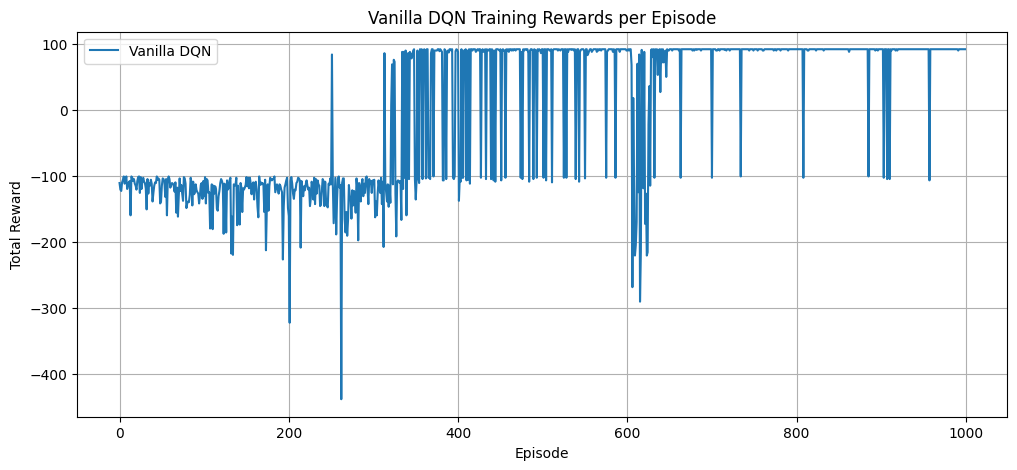

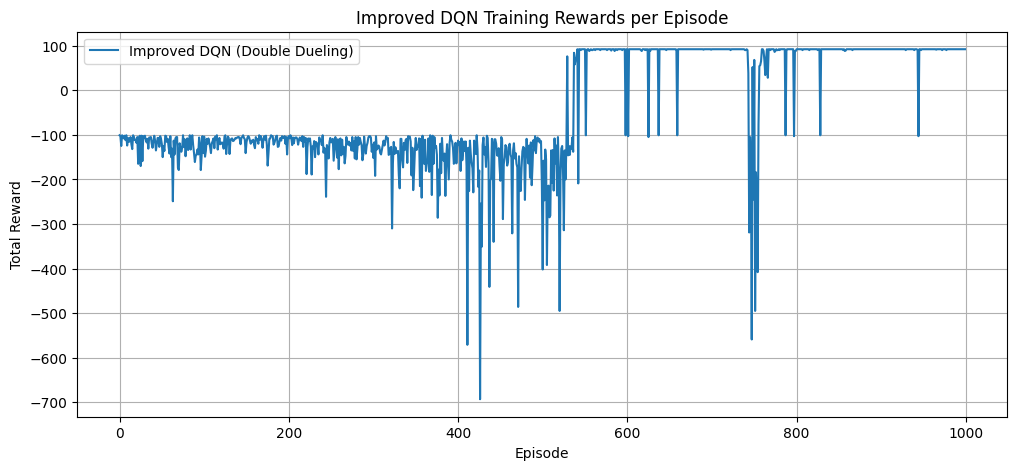

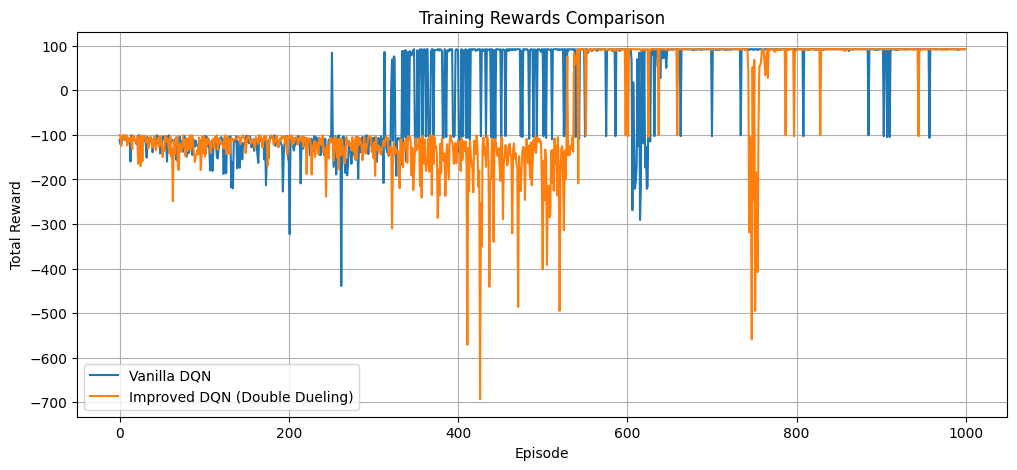

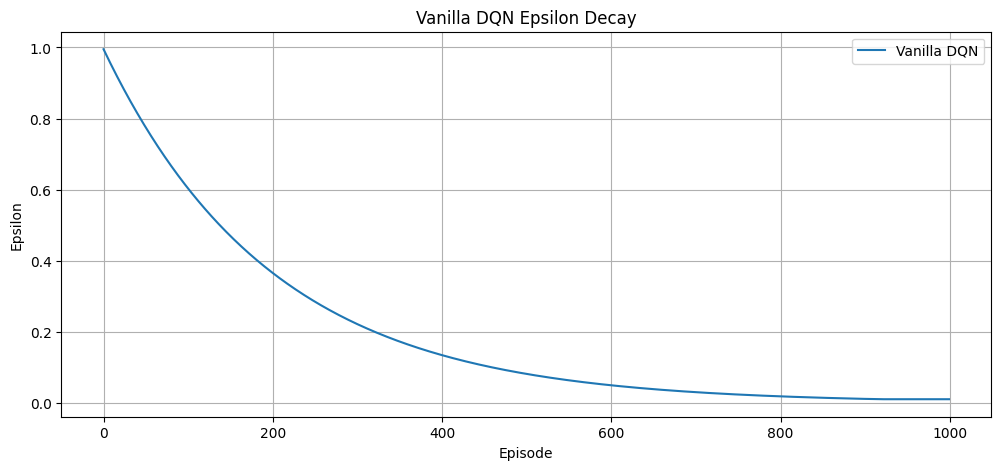

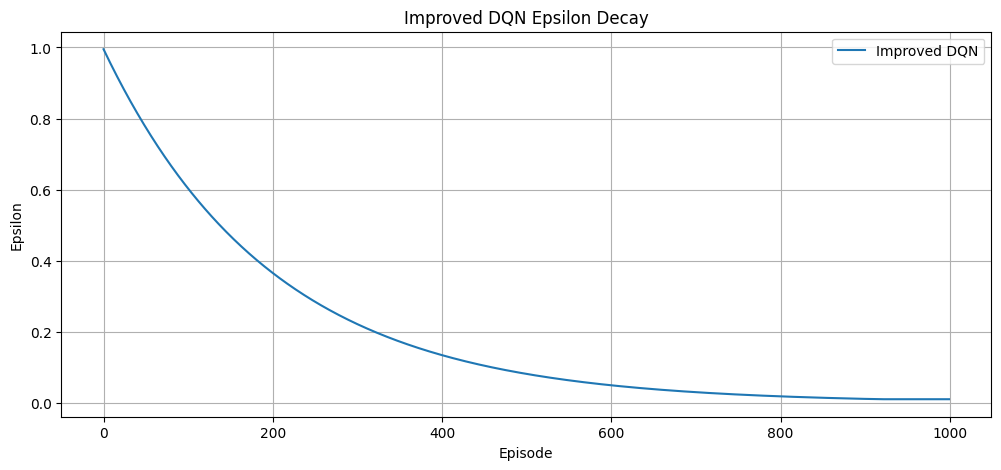

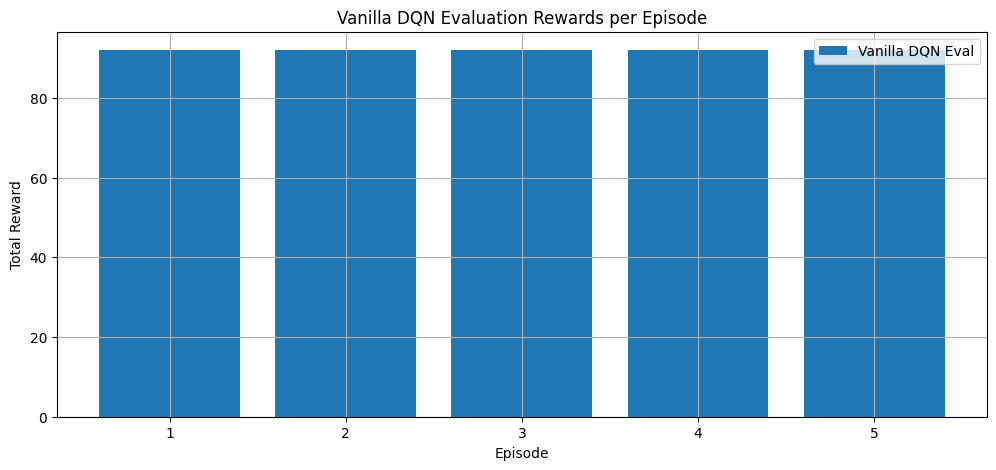

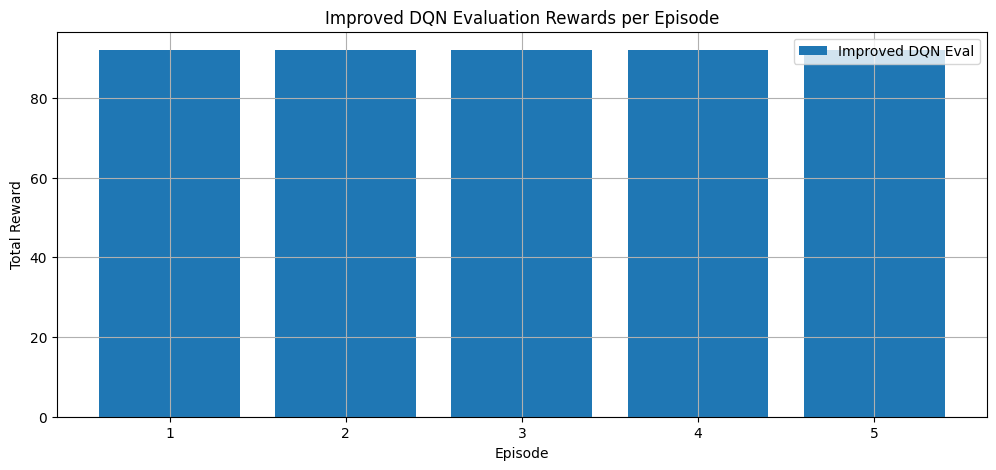


Running 1 episode with rendering (Improved DQN):
Steps taken by the agent:
Step 1: Action=0, Agent Position=[0 0]
Step 2: Action=2, Agent Position=[1 0]
Step 3: Action=0, Agent Position=[1 1]
Step 4: Action=0, Agent Position=[2 1]
Step 5: Action=0, Agent Position=[3 1]
Step 6: Action=2, Agent Position=[4 1]
Step 7: Action=2, Agent Position=[4 2]
Step 8: Action=2, Agent Position=[4 3]
Step 9: Action=2, Agent Position=[4 4]
Step 10: Final Frame, Agent Position=[4 5]

Saving and displaying frames from the episode:


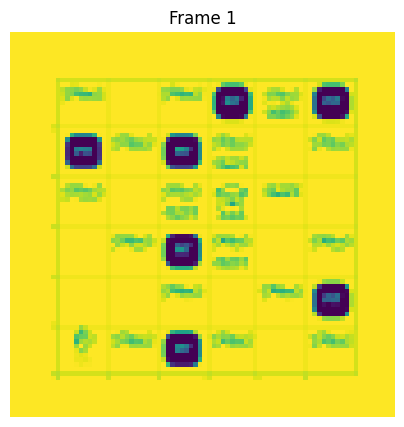

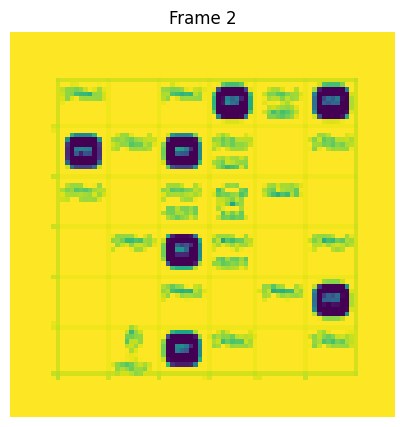

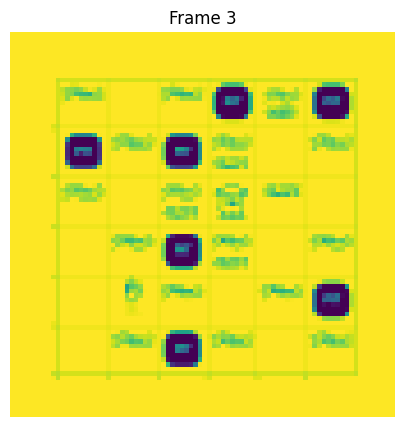

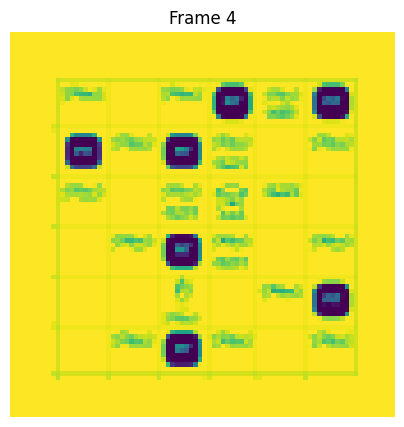

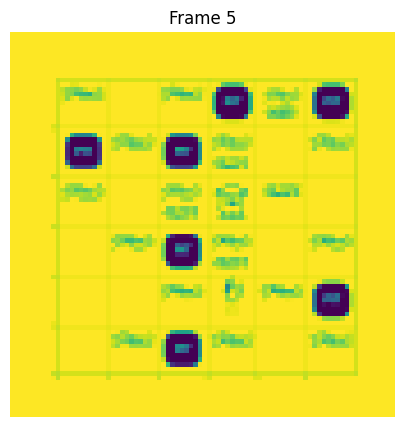

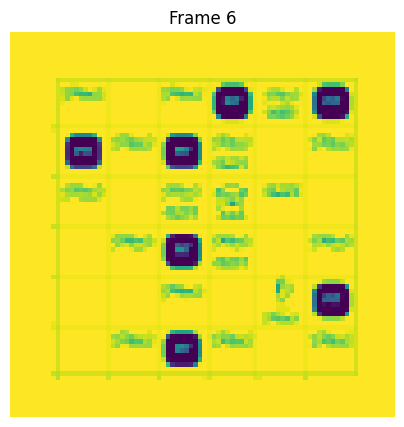

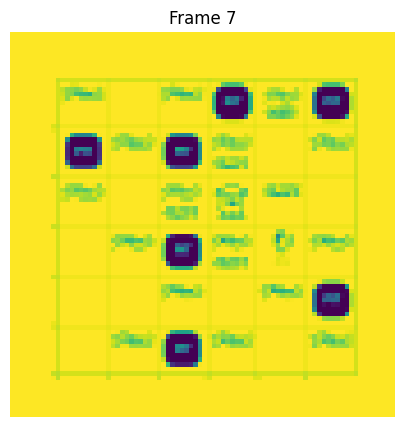

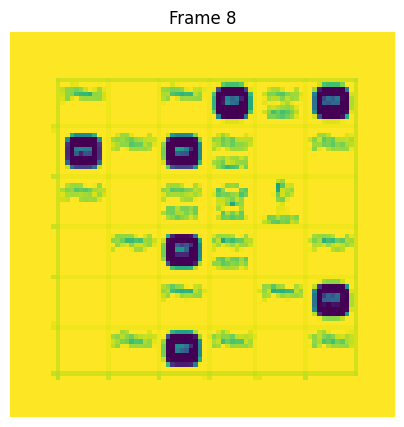

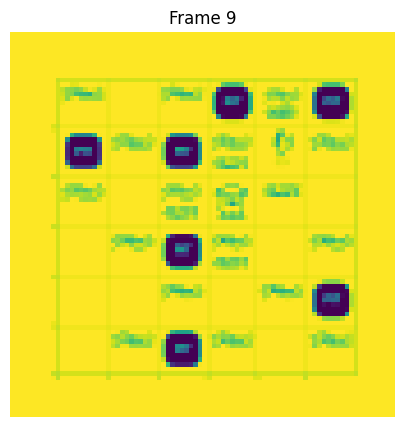

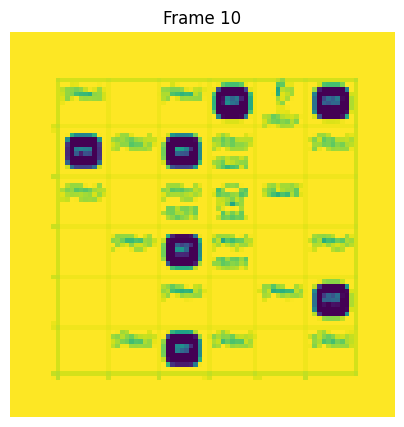

Frames saved in 'wumpus_renders' directory.


In [23]:
import cv2
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from environment import WumpusWorldEnvironment
import numpy as np
from time import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
import os

# Q-Network Definition for Vanilla DQN
class QNetwork(nn.Module):
    def __init__(self):
        """Initialize the Q-Network with 36 input states and 4 output actions."""
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(36, 64)
        self.fc2 = nn.Linear(64, 4) 
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Dueling Q-Network Definition for Improved DQN
class DuelingQNetwork(nn.Module):
    def __init__(self):
        """Initialize the Dueling Q-Network with separate value and advantage streams."""
        super(DuelingQNetwork, self).__init__()
        self.fc1 = nn.Linear(36, 64)         # Shared layer
        self.value_fc = nn.Linear(64, 1)     # Value stream
        self.advantage_fc = nn.Linear(64, 4) # Advantage stream
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        value = self.value_fc(x)
        advantages = self.advantage_fc(x)
        q_values = value + (advantages - advantages.mean(dim=1, keepdim=True))
        return q_values

# Utility Function
def state_to_onehot(state):
    """Convert integer state to one-hot encoded tensor."""
    onehot = np.zeros(36)
    onehot[state] = 1
    return torch.tensor(onehot, dtype=torch.float32).unsqueeze(0)

# Hyperparameters
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995
batch_size = 64
replay_buffer_size = 10000
target_update_freq = 100
learning_rate = 0.001
num_episodes = 1000

# Environment
env = WumpusWorldEnvironment(observation_type='integer', action_type='discrete')

# Function to train DQN (supports both vanilla and improved versions)
def train_dqn(network_type='vanilla'):
    if network_type == 'vanilla':
        q_network = QNetwork()
        target_network = QNetwork()
    else:  # 'improved'
        q_network = DuelingQNetwork()
        target_network = DuelingQNetwork()
    
    target_network.load_state_dict(q_network.state_dict())
    optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)
    replay_buffer = deque(maxlen=replay_buffer_size)
    episode_rewards = []
    epsilons = []
    epsilon = epsilon_start
    total_steps = 0
    
    print(f"Starting training ({network_type} DQN)...")
    for episode in range(num_episodes):
        state, _ = env.reset()
        state = state_to_onehot(state)
        total_reward = 0
        done = False
        
        while not done:
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    q_values = q_network(state)
                    action = torch.argmax(q_values).item()
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = state_to_onehot(next_state)
            total_reward += reward
            done = terminated or truncated
            
            replay_buffer.append((state, action, reward, next_state, terminated))
            
            if len(replay_buffer) >= batch_size:
                transitions = random.sample(replay_buffer, batch_size)
                states, actions, rewards, next_states, terminations = zip(*transitions)
                states = torch.cat(states)
                actions = torch.tensor(actions)
                rewards = torch.tensor(rewards, dtype=torch.float32)
                next_states = torch.cat(next_states)
                terminations = torch.tensor(terminations, dtype=torch.float32)
                
                with torch.no_grad():
                    if network_type == 'improved':
                        next_actions = q_network(next_states).argmax(dim=1)
                        next_q_values = target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
                    else:
                        next_q_values = target_network(next_states).max(dim=1)[0]
                    targets = rewards + gamma * next_q_values * (1 - terminations)
                
                current_q_values = q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                loss = F.mse_loss(current_q_values, targets)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            total_steps += 1
            if total_steps % target_update_freq == 0:
                target_network.load_state_dict(q_network.state_dict())
            
            state = next_state
        
        episode_rewards.append(total_reward)
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        epsilons.append(epsilon)
        print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.4f}")
    
    model_file = 'q_network.pth' if network_type == 'vanilla' else 'a3_part_3_dqn_gridworld_kumarsat_apurvaba.pth'
    torch.save(q_network.state_dict(), model_file)
    print(f"Model saved as '{model_file}'")
    return episode_rewards, epsilons, q_network

# Function to evaluate DQN
def evaluate_dqn(q_network, num_episodes=5):
    eval_rewards = []
    for i in range(num_episodes):
        state, _ = env.reset()
        state = state_to_onehot(state)
        total_reward = 0
        done = False
        while not done:
            with torch.no_grad():
                q_values = q_network(state)
                action = torch.argmax(q_values).item()
            state, reward, terminated, truncated, _ = env.step(action)
            state = state_to_onehot(state)
            total_reward += reward
            done = terminated or truncated
        eval_rewards.append(total_reward)
        print(f"Evaluation Episode {i + 1}, Total Reward: {total_reward}")
    return eval_rewards

# Train and Evaluate Vanilla DQN
vanilla_rewards, vanilla_epsilons, vanilla_q_network = train_dqn('vanilla')
print("\nTesting Vanilla DQN for 5 episodes:")
vanilla_eval_rewards = evaluate_dqn(vanilla_q_network)

# Train and Evaluate Improved DQN
improved_rewards, improved_epsilons, improved_q_network = train_dqn('improved')
print("\nTesting Improved DQN for 5 episodes:")
improved_eval_rewards = evaluate_dqn(improved_q_network)

# Plotting Results
# 1. Training Rewards (Separate Plots)
plt.figure(figsize=(12, 5))
plt.plot(vanilla_rewards, label='Vanilla DQN')
plt.title('Vanilla DQN Training Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(improved_rewards, label='Improved DQN (Double Dueling)')
plt.title('Improved DQN Training Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()

# 2. Training Rewards Comparison
plt.figure(figsize=(12, 5))
plt.plot(vanilla_rewards, label='Vanilla DQN')
plt.plot(improved_rewards, label='Improved DQN (Double Dueling)')
plt.title('Training Rewards Comparison')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()

# 3. Epsilon Decay (Separate Plots)
plt.figure(figsize=(12, 5))
plt.plot(vanilla_epsilons, label='Vanilla DQN')
plt.title('Vanilla DQN Epsilon Decay')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(improved_epsilons, label='Improved DQN')
plt.title('Improved DQN Epsilon Decay')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.legend()
plt.grid(True)
plt.show()

# 4. Evaluation Rewards (Bar Plots)
plt.figure(figsize=(12, 5))
plt.bar(range(1, len(vanilla_eval_rewards) + 1), vanilla_eval_rewards, label='Vanilla DQN Eval')
plt.title('Vanilla DQN Evaluation Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.xticks(range(1, len(vanilla_eval_rewards) + 1))
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.bar(range(1, len(improved_eval_rewards) + 1), improved_eval_rewards, label='Improved DQN Eval')
plt.title('Improved DQN Evaluation Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.xticks(range(1, len(improved_eval_rewards) + 1))
plt.legend()
plt.grid(True)
plt.show()

# Render 1 Episode with Improved DQN and Save Frames
print("\nRunning 1 episode with rendering (Improved DQN):")
os.makedirs('wumpus_renders', exist_ok=True)  # Create directory for renders
images = []
state, _ = env.reset()
state = state_to_onehot(state)
done = False
step_count = 0

print("Steps taken by the agent:")
while not done:
    img = env.render(plot=False)
    images.append(img)
    with torch.no_grad():
        q_values = improved_q_network(state)
        action = torch.argmax(q_values).item()
    print(f"Step {step_count + 1}: Action={action}, Agent Position={env.agent_pos}")
    state, reward, terminated, truncated, _ = env.step(action)
    state = state_to_onehot(state)
    done = terminated or truncated
    step_count += 1

img = env.render(plot=False)
images.append(img)
print(f"Step {step_count + 1}: Final Frame, Agent Position={env.agent_pos}")

# Save and Display Frames
print("\nSaving and displaying frames from the episode:")
for i, img in enumerate(images):
    filename = f'wumpus_renders/frame_{i + 1}.png'
    cv2.imwrite(filename, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))  # Save as PNG
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"Frame {i + 1}")
    plt.axis('off')
    plt.show(block=False)
    plt.pause(0.1)
    plt.close()
print(f"Frames saved in 'wumpus_renders' directory.")

# CartPole & LunarLander

Running CartPole-v1 environment...
Training Vanilla DQN...
Episode 100	Average Score: 17.760
Episode 200	Average Score: 41.186.0
Episode 300	Average Score: 246.49.0
Episode 400	Average Score: 212.52.0
Episode 500	Average Score: 226.43.0
Episode 600	Average Score: 258.12.0
Episode 700	Average Score: 196.26.0
Episode 800	Average Score: 123.82.0
Episode 900	Average Score: 144.05.0
Episode 1000	Average Score: 344.72.0
Episode 1100	Average Score: 341.70.0
Episode 1200	Average Score: 473.17.0
Episode 1257	Average Score: 490.09.0
Environment solved in 1257 episodes!	Average Score: 490.09


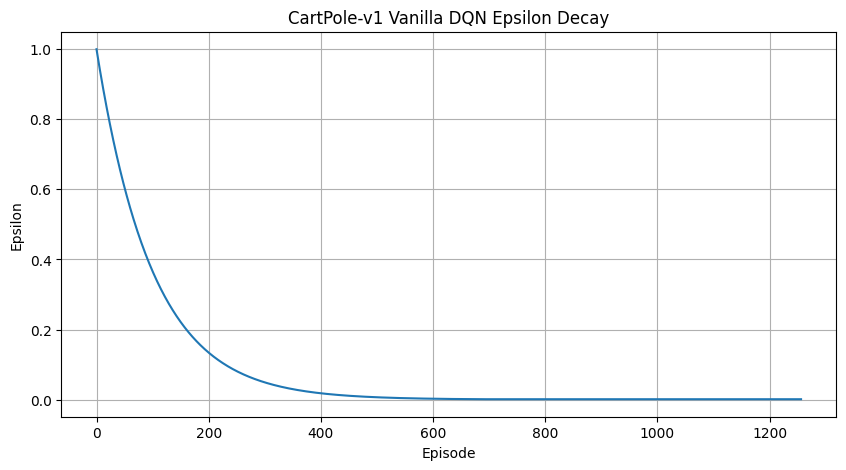

Training Improved DQN (Double DQN + Dueling DQN)...
Episode 100	Average Score: 19.710
Episode 200	Average Score: 56.208.0
Episode 300	Average Score: 274.70.0
Episode 400	Average Score: 264.81.0
Episode 500	Average Score: 250.39.0
Episode 600	Average Score: 230.18.0
Episode 700	Average Score: 259.64.0
Episode 800	Average Score: 353.93.0
Episode 900	Average Score: 482.13.0
Episode 1000	Average Score: 428.35.0
Episode 1100	Average Score: 474.95.0
Episode 1200	Average Score: 474.91.0
Episode 1249	Average Score: 490.62.0
Environment solved in 1249 episodes!	Average Score: 490.62


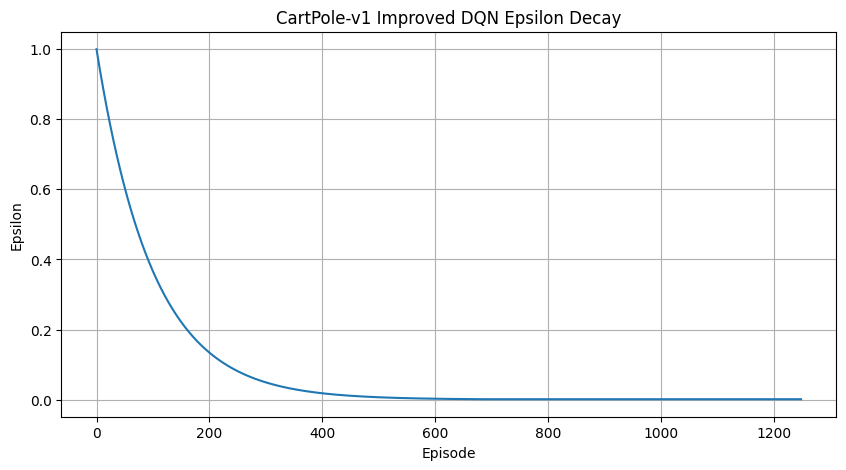

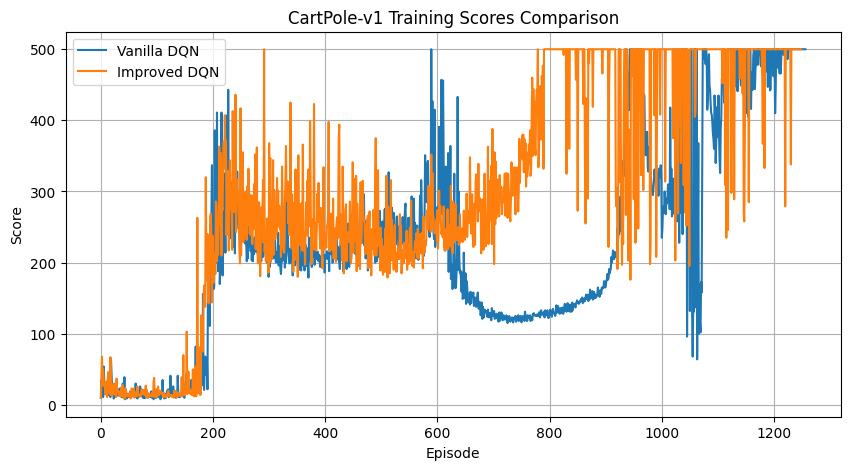


Evaluating Vanilla DQN...
Episode 1	Score: 500.00
Episode 2	Score: 500.00
Episode 3	Score: 500.00
Episode 4	Score: 500.00
Episode 5	Score: 500.00


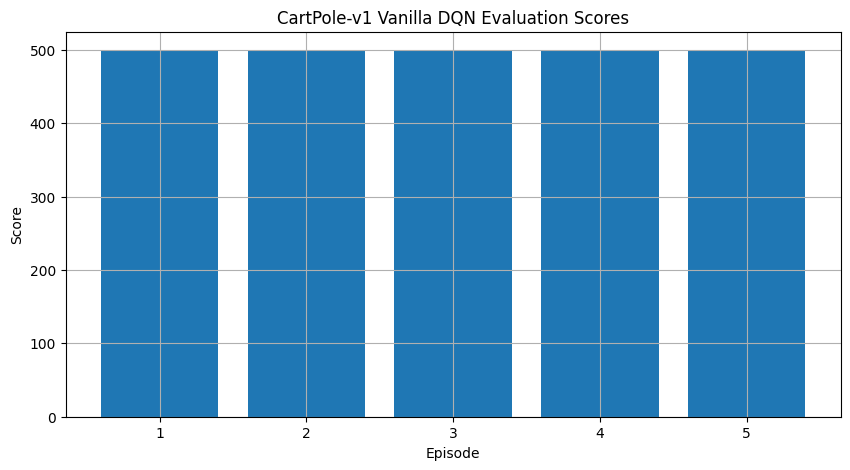


Evaluating Improved DQN...
Episode 1	Score: 500.00
Episode 2	Score: 500.00
Episode 3	Score: 500.00
Episode 4	Score: 500.00
Episode 5	Score: 500.00


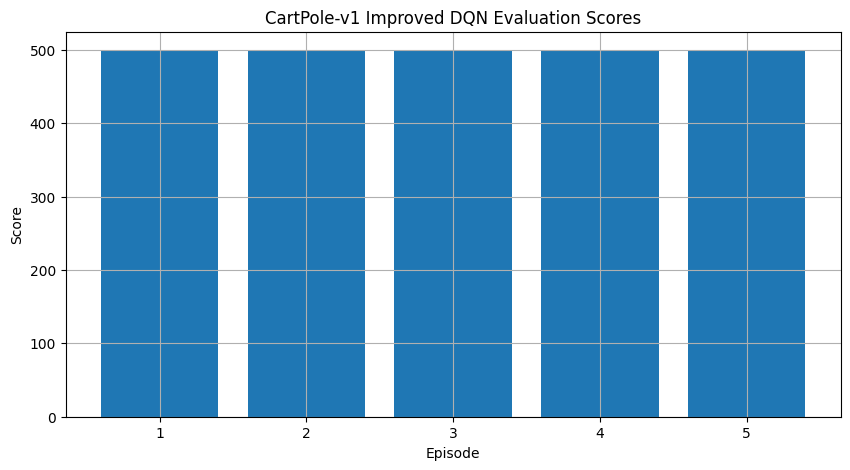


Running LunarLander-v3 environment...
Training Vanilla DQN...
Episode 100	Average Score: -139.72338127546358346
Episode 200	Average Score: -92.077.39572815949193
Episode 300	Average Score: -26.01.7401566002683034
Episode 400	Average Score: 127.07.3589802930908766
Episode 500	Average Score: 176.30.9927565285806857
Episode 600	Average Score: 177.96.421852337163675
Episode 700	Average Score: 195.71.4951116845783273
Episode 727	Average Score: 200.19.65524359292866
Environment solved in 727 episodes!	Average Score: 200.19


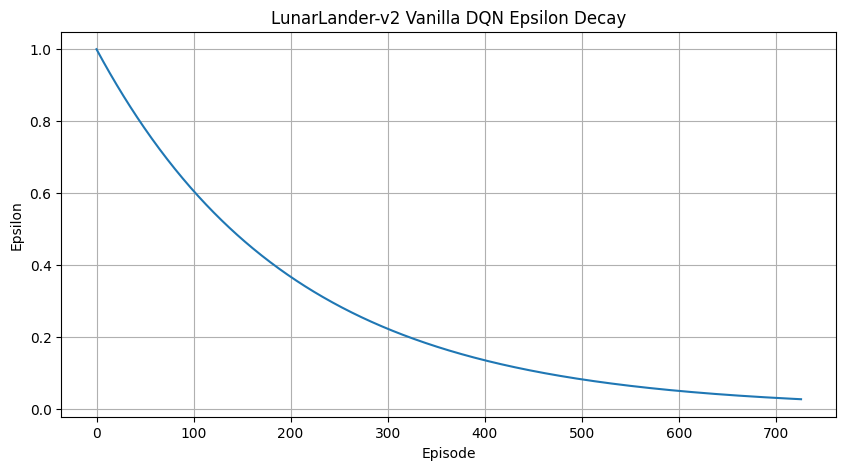

Training Improved DQN (Double DQN + Dueling DQN)...
Episode 100	Average Score: -178.82160181097610426
Episode 200	Average Score: -97.31.1331353374318426
Episode 300	Average Score: -40.953.127618836212082
Episode 400	Average Score: 37.257.5846251961823628
Episode 500	Average Score: 193.06.705790080731933
Episode 523	Average Score: 201.13.169135408363162
Environment solved in 523 episodes!	Average Score: 201.13


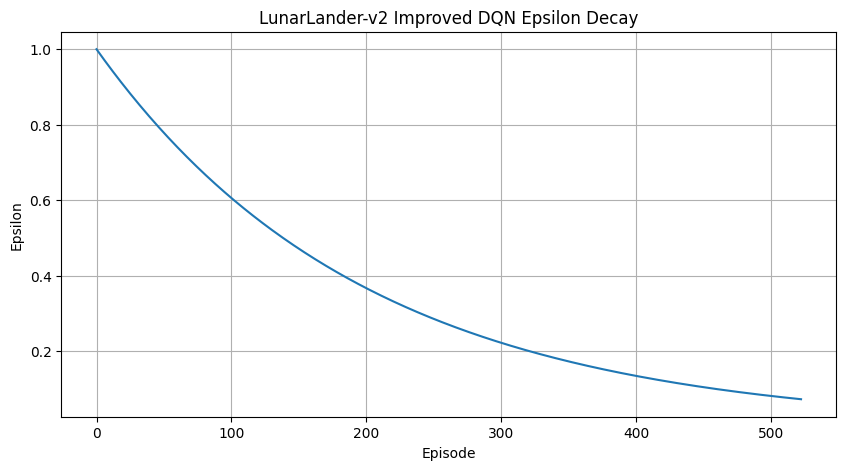

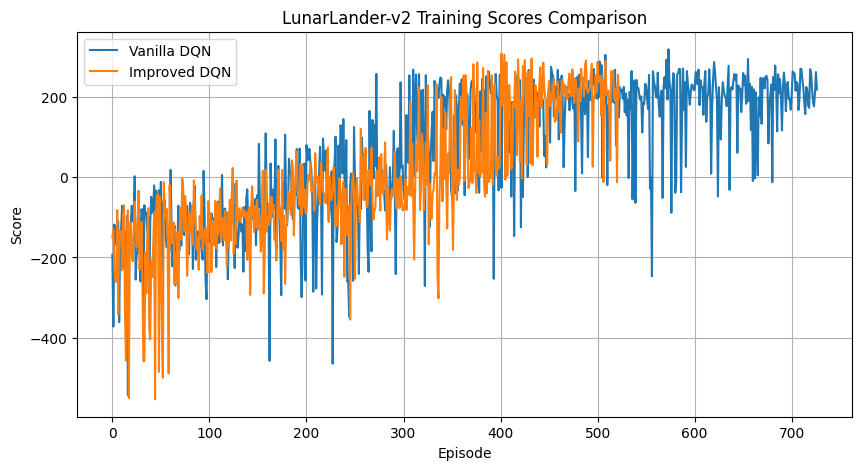


Evaluating Vanilla DQN...
Episode 1	Score: 254.24
Episode 2	Score: 238.68
Episode 3	Score: 201.29
Episode 4	Score: 78.57
Episode 5	Score: 287.63


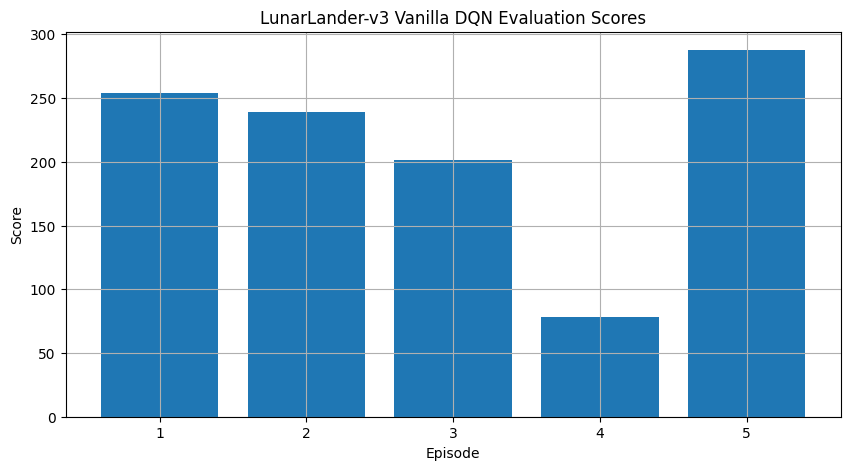


Evaluating Improved DQN...
Episode 1	Score: 196.68
Episode 2	Score: 101.90
Episode 3	Score: 287.43
Episode 4	Score: 216.41
Episode 5	Score: 298.01


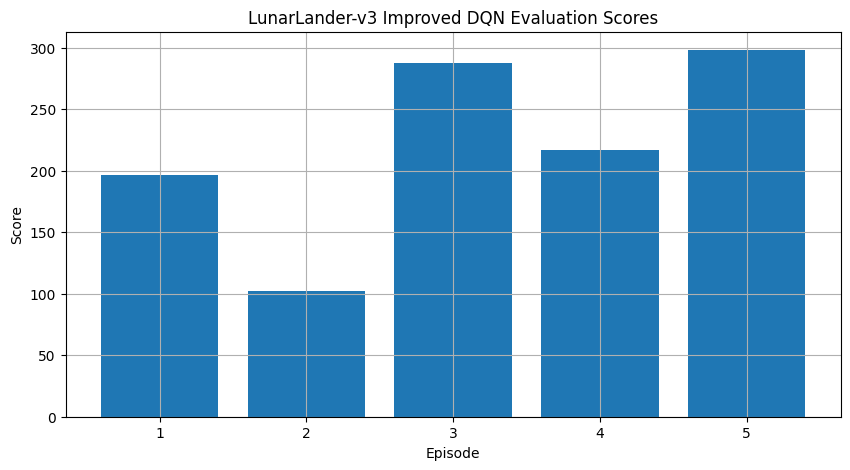

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
from collections import deque, namedtuple
import random
import matplotlib.pyplot as plt
from typing import List, Tuple

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

class QNetwork(nn.Module):
    def __init__(self, state_size: int, action_size: int, seed: int = 42):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class DuelingQNetwork(nn.Module):
    def __init__(self, state_size: int, action_size: int, seed: int = 42):
        super(DuelingQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.value_stream = nn.Linear(64, 1)
        self.advantage_stream = nn.Linear(64, action_size)
        
    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        value = self.value_stream(x)
        advantages = self.advantage_stream(x)
        q_values = value + (advantages - advantages.mean(dim=1, keepdim=True))
        return q_values

class ReplayBuffer:
    def __init__(self, buffer_size: int, batch_size: int, seed: int = 42):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        e = Experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float().to(device)
        dones = torch.from_numpy(np.vstack([int(e.done) for e in experiences])).float().to(device)
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        return len(self.memory)

class DQNAgent:
    def __init__(self, state_size: int, action_size: int, config: dict, use_dueling: bool = False, use_double_dqn: bool = False):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(config['seed'])
        self.use_dueling = use_dueling
        self.use_double_dqn = use_double_dqn
        
        if use_dueling:
            self.qnetwork_local = DuelingQNetwork(state_size, action_size, config['seed']).to(device)
            self.qnetwork_target = DuelingQNetwork(state_size, action_size, config['seed']).to(device)
        else:
            self.qnetwork_local = QNetwork(state_size, action_size, config['seed']).to(device)
            self.qnetwork_target = QNetwork(state_size, action_size, config['seed']).to(device)
        
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=config['lr'], weight_decay=1e-5)
        self.memory = ReplayBuffer(config['buffer_size'], config['batch_size'], config['seed'])
        self.t_step = 0
        self.gamma = config['gamma']
        self.tau = config['tau']
        self.update_every = config['update_every']
        self.batch_size = config['batch_size']
        
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0 and len(self.memory) > self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences)

    def act(self, state, eps: float = 0.):
        if isinstance(state, tuple):
            state = state[0]
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    
    def learn(self, experiences: Tuple):
        states, actions, rewards, next_states, dones = experiences
        if self.use_double_dqn:
            next_actions = self.qnetwork_local(next_states).detach().argmax(1).unsqueeze(1)
            Q_targets_next = self.qnetwork_target(next_states).detach().gather(1, next_actions)
        else:
            Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        loss = nn.MSELoss()(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)
    
    def soft_update(self, local_model, target_model, tau: float):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

def train_dqn(env, agent: DQNAgent, model_path: str, n_episodes: int = 2000, max_t: int = 500, eps_start: float = 1.0, 
              eps_end: float = 0.001, eps_decay: float = 0.99, solve_score: float = None):
    scores = []
    scores_window = deque(maxlen=100)
    eps_history = []
    eps = eps_start
    for i_episode in range(1, n_episodes + 1):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, truncated, _ = env.step(action)
            done = done or truncated
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                print(f"\rEpisode {i_episode}\tSteps: {t+1}\tScore: {score}", end="")
                break
        scores_window.append(score)
        scores.append(score)
        eps_history.append(eps)
        eps = max(eps_end, eps_decay * eps)
        avg_score = np.mean(scores_window)
        print(f'\rEpisode {i_episode}\tAverage Score: {avg_score:.2f}', end="")
        if i_episode % 100 == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {avg_score:.2f}')
        if solve_score and avg_score >= solve_score:
            print(f'\nEnvironment solved in {i_episode} episodes!\tAverage Score: {avg_score:.2f}')
            break
    torch.save({
        'qnetwork_local': agent.qnetwork_local.state_dict(),
        'qnetwork_target': agent.qnetwork_target.state_dict(),
        'optimizer': agent.optimizer.state_dict(),
        'config': {'gamma': agent.gamma, 'tau': agent.tau, 'update_every': agent.update_every, 'batch_size': agent.batch_size}
    }, model_path)
    return scores, eps_history

def load_agent(file_path: str, state_size: int, action_size: int, config: dict, use_dueling: bool = False, use_double_dqn: bool = False) -> DQNAgent:
    checkpoint = torch.load(file_path)
    agent = DQNAgent(state_size, action_size, config, use_dueling, use_double_dqn)
    agent.qnetwork_local.load_state_dict(checkpoint['qnetwork_local'])
    agent.qnetwork_target.load_state_dict(checkpoint['qnetwork_target'])
    agent.optimizer.load_state_dict(checkpoint['optimizer'])
    return agent

def evaluate(env, file_path: str, state_size: int, action_size: int, config: dict, use_dueling: bool = False, use_double_dqn: bool = False, n_episodes: int = 5, max_t: int = 500, render: bool = False):
    agent = load_agent(file_path, state_size, action_size, config, use_dueling, use_double_dqn)
    scores = []
    for i_episode in range(1, n_episodes + 1):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        score = 0
        for t in range(max_t):
            if render:
                env.render()
            action = agent.act(state, eps=0)
            next_state, reward, done, truncated, _ = env.step(action)
            done = done or truncated
            state = next_state
            score += reward
            if done:
                break
        scores.append(score)
        print(f'Episode {i_episode}\tScore: {score:.2f}')
    return scores

def plot_scores(scores_list: List[List[float]], labels: List[str], title: str = "Training Scores"):
    plt.figure(figsize=(10, 5))
    for scores, label in zip(scores_list, labels):
        plt.plot(scores, label=label)
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_epsilon_decay(eps_history: List[float], title: str = "Epsilon Decay"):
    plt.figure(figsize=(10, 5))
    plt.plot(eps_history)
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.grid(True)
    plt.show()

def plot_evaluation(scores: List[float], title: str = "Evaluation Scores"):
    plt.figure(figsize=(10, 5))
    plt.bar(range(1, len(scores) + 1), scores)
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.xticks(range(1, len(scores) + 1))
    plt.grid(True)
    plt.show()

def run_cartpole():
    print("Running CartPole-v1 environment...")
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    config = {
        'seed': 42,
        'lr': 0.0005,
        'gamma': 0.99,
        'tau': 5e-3,
        'buffer_size': int(1e5),
        'batch_size': 128,
        'update_every': 4
    }
    
    # Vanilla DQN
    print("Training Vanilla DQN...")
    vanilla_agent = DQNAgent(state_size, action_size, config, use_dueling=False, use_double_dqn=False)
    vanilla_scores, vanilla_eps = train_dqn(
        env, vanilla_agent, 
        'a2_part_2_dqn_cartpole.pth', 
        n_episodes=2000, 
        max_t=500, 
        eps_start=1.0, 
        eps_end=0.001, 
        eps_decay=0.99, 
        solve_score=490
    )
    plot_epsilon_decay(vanilla_eps, "CartPole-v1 Vanilla DQN Epsilon Decay")
    
    # Improved DQN
    print("Training Improved DQN (Double DQN + Dueling DQN)...")
    improved_agent = DQNAgent(state_size, action_size, config, use_dueling=True, use_double_dqn=True)
    improved_scores, improved_eps = train_dqn(
        env, improved_agent, 
        'a3_part_3_dqn_cartpole.pth', 
        n_episodes=2000, 
        max_t=500, 
        eps_start=1.0, 
        eps_end=0.001, 
        eps_decay=0.99, 
        solve_score=490
    )
    plot_epsilon_decay(improved_eps, "CartPole-v1 Improved DQN Epsilon Decay")
    
    # Compare training scores
    plot_scores([vanilla_scores, improved_scores], ['Vanilla DQN', 'Improved DQN'], "CartPole-v1 Training Scores Comparison")
    
    # Evaluate
    print("\nEvaluating Vanilla DQN...")
    vanilla_eval = evaluate(
        env, 'a2_part_2_dqn_cartpole.pth', 
        state_size, action_size, config, 
        use_dueling=False, use_double_dqn=False,
        n_episodes=5
    )
    plot_evaluation(vanilla_eval, "CartPole-v1 Vanilla DQN Evaluation Scores")
    
    print("\nEvaluating Improved DQN...")
    improved_eval = evaluate(
        env, 'a3_part_3_dqn_cartpole.pth', 
        state_size, action_size, config, 
        use_dueling=True, use_double_dqn=True,
        n_episodes=5
    )
    plot_evaluation(improved_eval, "CartPole-v1 Improved DQN Evaluation Scores")
    
    env.close()
    return vanilla_scores, improved_scores

def run_lunar_lander():
    print("\nRunning LunarLander-v3 environment...")
    env = gym.make('LunarLander-v3')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    config = {
        'seed': 42,
        'lr': 0.0005,
        'gamma': 0.99,
        'tau': 1e-3,
        'buffer_size': int(1e5),
        'batch_size': 128,
        'update_every': 4
    }
    
    # Vanilla DQN
    print("Training Vanilla DQN...")
    vanilla_agent = DQNAgent(state_size, action_size, config, use_dueling=False, use_double_dqn=False)
    vanilla_scores, vanilla_eps = train_dqn(
        env, vanilla_agent, 
        'a2_part_2_dqn_lunarlander.pth', 
        n_episodes=3000, 
        max_t=1000, 
        eps_start=1.0, 
        eps_end=0.01, 
        eps_decay=0.995, 
        solve_score=200
    )
    plot_epsilon_decay(vanilla_eps, "LunarLander-v2 Vanilla DQN Epsilon Decay")
    
    # Improved DQN
    print("Training Improved DQN (Double DQN + Dueling DQN)...")
    improved_agent = DQNAgent(state_size, action_size, config, use_dueling=True, use_double_dqn=True)
    improved_scores, improved_eps = train_dqn(
        env, improved_agent, 
        'a3_part_3_dqn_lunarlander.pth', 
        n_episodes=3000, 
        max_t=1000, 
        eps_start=1.0, 
        eps_end=0.01, 
        eps_decay=0.995, 
        solve_score=200
    )
    plot_epsilon_decay(improved_eps, "LunarLander-v2 Improved DQN Epsilon Decay")
    
    # Compare training scores
    plot_scores([vanilla_scores, improved_scores], ['Vanilla DQN', 'Improved DQN'], "LunarLander-v2 Training Scores Comparison")
    
    # Evaluate
    print("\nEvaluating Vanilla DQN...")
    vanilla_eval = evaluate(
        env, 'a2_part_2_dqn_lunarlander.pth', 
        state_size, action_size, config, 
        use_dueling=False, use_double_dqn=False,
        n_episodes=5
    )
    plot_evaluation(vanilla_eval, "LunarLander-v3 Vanilla DQN Evaluation Scores")
    
    print("\nEvaluating Improved DQN...")
    improved_eval = evaluate(
        env, 'a3_part_3_dqn_lunarlander.pth', 
        state_size, action_size, config, 
        use_dueling=True, use_double_dqn=True,
        n_episodes=5
    )
    plot_evaluation(improved_eval, "LunarLander-v3 Improved DQN Evaluation Scores")
    
    env.close()
    return vanilla_scores, improved_scores

if __name__ == "__main__":
    cartpole_vanilla, cartpole_improved = run_cartpole()
    lunar_vanilla, lunar_improved = run_lunar_lander()